# 1. Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer  # Class for imputing missing values using K-Nearest Neighbors
from sklearn.preprocessing import StandardScaler

# Data loading
try:
    df = pd.read_csv("CMU Sleep.csv")
except FileNotFoundError:  # Raised when attempting to access a file that does not exist
    print("CSV file not found.")

# Convert columns to numeric types
''' 
If a column contains whitespace (' '), empty strings (''), or string-based values ('NaN', 'null', etc.),
pandas treats the entire column as an object (string) type.
Even if most values are numeric, this prevents numerical analysis such as machine learning, 
statistical operations, or imputation.

To resolve this, the following columns are explicitly converted to float64.
Values that cannot be converted are coerced to NaN for further processing.
'''
columns_to_convert = [
    "demo_race",
    "demo_gender",
    "demo_firstgen",
    "term_units",
    "Zterm_units_ZofZ"
]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check data types after conversion
print("Data types after numeric conversion:")
print(df[columns_to_convert].dtypes)

Data types after numeric conversion:
demo_race           float64
demo_gender         float64
demo_firstgen       float64
term_units          float64
Zterm_units_ZofZ    float64
dtype: object


# 2. Encoding

In [4]:
# Convert the 'cohort' column into one-hot encoded variables
df = pd.get_dummies(df, columns=["cohort"], prefix="cohort")

# Check the resulting one-hot encoded cohort columns
print([col for col in df.columns if col.startswith("cohort_")])

['cohort_lac1', 'cohort_lac2', 'cohort_nh', 'cohort_uw1', 'cohort_uw2']


# 3. Analyze feature importance

In [6]:
def get_feature_importance(X, y, model, top_n=None, title="Feature Importance", figsize=(8, 5)):
    """
    Trains the given model and outputs & visualizes feature importance.

    Args:
        X (DataFrame): Input features
        y (Series or ndarray): Target variable
        model (sklearn estimator): Model to train
        top_n (int): Display only the top N important features (None to display all)
        title (str): Title of the plot
        figsize (tuple): Size of the figure for visualization

    Returns:
        DataFrame: Table of feature importances
    """
    model.fit(X, y)

    # Extract feature importance
    if hasattr(model, "feature_importances_"):  # Check if the model has the 'feature_importances_' attribute
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        # If 'feature_importances_' is not available, check for 'coef_' attribute
        importances = model.coef_.ravel() if len(model.coef_.shape) == 2 else model.coef_
    else:
        raise ValueError("This model does not provide feature importance.")

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    # Visualization
    plt.figure(figsize=figsize)
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return importance_df

### term_gpa

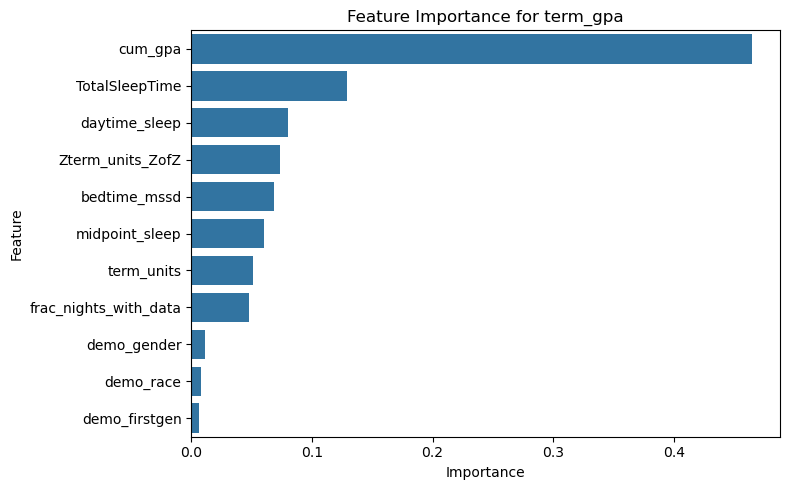

In [8]:
# RandomForestRegressor is a model that improves prediction accuracy for regression tasks using an ensemble of decision trees.
from sklearn.ensemble import RandomForestRegressor

# Define the list of features to be used for model training.
features = [
    'TotalSleepTime', 'bedtime_mssd', 'midpoint_sleep', 'daytime_sleep',
    'cum_gpa', 'Zterm_units_ZofZ', 'demo_gender', 'demo_race', 'demo_firstgen',
    'term_units', 'frac_nights_with_data'
]

# Features such as subject_id, study, and cohort are excluded from the predictors to prevent data leakage, overfitting, and to enhance generalizability.

# Create a new DataFrame (df_clean) by selecting only the relevant features and the target variable ('term_gpa'),
# and dropping rows with missing values (NaN).
df_clean = df[features + ['term_gpa']].dropna()

# Define the input features (X) from df_clean based on the selected feature list.
X = df_clean[features]

# Define the target variable (y) from the 'term_gpa' column.
y = df_clean['term_gpa']

# Use the RandomForestRegressor model to calculate feature importances and visualize the results
importance_table = get_feature_importance(
    X,  
    y,  
    model=RandomForestRegressor(random_state=42),
    title="Feature Importance for term_gpa"
)

A total of 8 variables were prioritized during preprocessing:

cum_gpa, TotalSleepTime, daytime_sleep, bedtime_mssd, Zterm_units_ZofZ, midpoint_sleep, term_units, and frac_nights_with_data.

### term_units

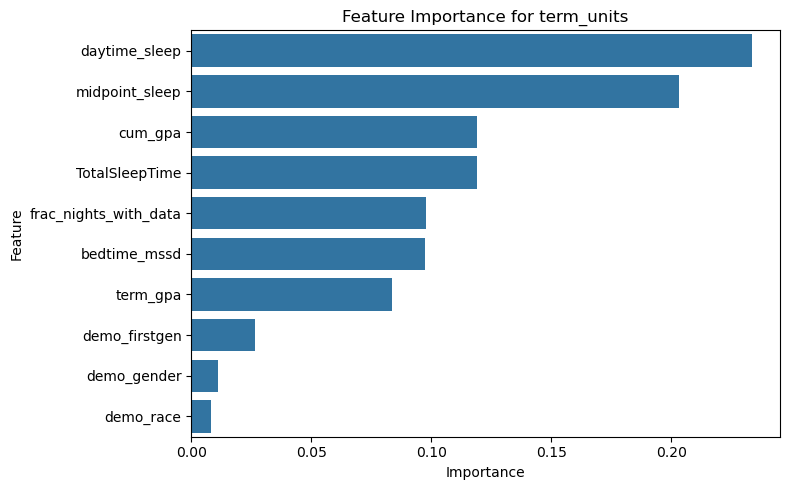

In [11]:
# Define the list of features to be used for model training.
features = [
    'TotalSleepTime', 'bedtime_mssd', 'midpoint_sleep', 'daytime_sleep',
    'cum_gpa', 'demo_gender', 'demo_race', 'demo_firstgen',
    'term_gpa', 'frac_nights_with_data'
]

# Variables such as subject_id, study, and cohort are excluded from the prediction features 
# to prevent overfitting, ensure generalization, and avoid data leakage.

# Create a new DataFrame (df_clean) by selecting only the relevant features and the target variable ('term_units') from the original DataFrame,
# and removing rows that contain missing values (NaNs).
df_clean = df[features + ['term_units']].dropna()

# Define input features (X) from the df_clean DataFrame using the selected features.
X = df_clean[features]

# Define the target variable (y) from the 'term_units' column in df_clean.
y = df_clean['term_units']

# Use the RandomForestRegressor model to compute feature importances and visualize the results
importance_table = get_feature_importance(
    X,  
    y,  
    model=RandomForestRegressor(random_state=42),
    title="Feature Importance for term_units"
)

A total of 8 variables were prioritized for KNN imputation:

cum_gpa, TotalSleepTime, daytime_sleep, bedtime_mssd, Zterm_units_ZofZ, midpoint_sleep, term_gpa, and frac_nights_with_data.

# 4. Missing Value

In [14]:
def preprocess_missing_values(df: pd.DataFrame, columns_to_convert: list) -> pd.DataFrame:
    """
    Handles missing values in selected columns of the CMU Sleep dataset and prints information about imputed cells.

    Processing strategy:
    - demo_* columns: Impute with the mode value.
    - term_units column: Impute using KNN Imputer (includes the study column).
    - Zterm_units_ZofZ column: Computed using two-step Z-score normalization as described in the dataset guide:
        1) First Z-score within each 'study' group.
        2) Second Z-score across all participants.
    - Prints the location and values of imputed cells for review.

    Args:
        df (pd.DataFrame): DataFrame to perform missing value imputation on.
        columns_to_convert (list): List of target columns to track for missing value imputation.

    Returns:
        pd.DataFrame: The DataFrame with missing values processed.
    """

    # Record missing positions before imputation (for tracking imputed values)
    missing_mask = df[columns_to_convert].isnull()

    # Impute demo_* (demographic) columns with mode value
    for col in ["demo_race", "demo_gender", "demo_firstgen"]:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

    # Impute 'term_units' using KNN Imputer
    knn_features = [
        'cum_gpa', 'TotalSleepTime', 'daytime_sleep', 'bedtime_mssd',
        'midpoint_sleep', 'term_gpa', 'frac_nights_with_data',
        'term_units'
    ]
    knn_df = df[knn_features].copy()

    imputer = KNNImputer(n_neighbors=5)
    knn_result = imputer.fit_transform(knn_df)
    df["term_units"] = knn_result[:, knn_features.index("term_units")]

    # Round term_units to integer values after imputation
    df["term_units"] = np.round(df["term_units"]).astype(int)

    # Compute two-step Z-score for 'Zterm_units_ZofZ'
    df["Z1"] = (
        df["term_units"] - df.groupby("study")["term_units"].transform("mean")
    ) / df.groupby("study")["term_units"].transform("std")

    z1_mean = df["Z1"].mean()
    z1_std = df["Z1"].std()
    df["Zterm_units_ZofZ"] = (df["Z1"] - z1_mean) / z1_std

    df.drop(columns=["Z1"], inplace=True)

    # Print remaining missing values
    print("Remaining missing values after processing:")
    print(df.isnull().sum())

    # Show example of imputed cells
    filled_values = []
    for col in columns_to_convert:
        for idx in missing_mask.index[missing_mask[col]]:
            value = df.loc[idx, col]
            filled_values.append({"index": idx, "column": col, "filled_value": value})

    filled_df = pd.DataFrame(filled_values)
    print("\nExamples of imputed values (up to 20):")
    print(filled_df.head(20))

    # Compare mean of imputed 'term_units' values to overall mean
    filled_term_units = filled_df[filled_df["column"] == "term_units"]["filled_value"].astype(float)
    overall_mean = df["term_units"].mean()

    print("\n'term_units' column:")
    print(f"  Mean of imputed values: {filled_term_units.mean():.2f}")
    print(f"  Overall mean: {overall_mean:.2f}")

    return df

df = preprocess_missing_values(df, columns_to_convert)

Remaining missing values after processing:
subject_id               0
study                    0
demo_race                0
demo_gender              0
demo_firstgen            0
bedtime_mssd             0
TotalSleepTime           0
midpoint_sleep           0
frac_nights_with_data    0
daytime_sleep            0
cum_gpa                  0
term_gpa                 0
term_units               0
Zterm_units_ZofZ         0
cohort_lac1              0
cohort_lac2              0
cohort_nh                0
cohort_uw1               0
cohort_uw2               0
dtype: int64

Examples of imputed values (up to 20):
    index         column  filled_value
0     583      demo_race           1.0
1      28    demo_gender           1.0
2     223    demo_gender           1.0
3     224    demo_gender           1.0
4     630  demo_firstgen           0.0
5     631  demo_firstgen           0.0
6     632  demo_firstgen           0.0
7     633  demo_firstgen           0.0
8     215     term_units          16.0
9

# 5. Wrong data

In [23]:
# Replace invalid value 2 in the 'demo_firstgen' column with the mode value

# Calculate the mode (most frequent value) among valid values (0 or 1)
valid_mode = df.loc[df['demo_firstgen'].isin([0, 1]), 'demo_firstgen'].mode().iloc[0]

# Replace any instance of the invalid value 2 with the valid mode
df.loc[df['demo_firstgen'] == 2, 'demo_firstgen'] = valid_mode

# Display the value distribution after correction
print("Distribution of 'demo_firstgen' values:")
print(df['demo_firstgen'].value_counts())

Distribution of 'demo_firstgen' values:
demo_firstgen
0.0    531
1.0    103
Name: count, dtype: int64


# 6. Outlier detection

In [28]:
# List of target features for outlier detection
outlier_features = [ 
    "cum_gpa", "TotalSleepTime", "daytime_sleep", "bedtime_mssd", 
    "Zterm_units_ZofZ", "midpoint_sleep"
]

def detect_outliers_zscore(df, features, threshold=2.5):
    """
    Detect outliers for the specified features using the Z-score method.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        features (list): A list of feature (column) names to check for outliers.
        threshold (float): Absolute Z-score threshold for flagging an outlier.

    Returns:
        dict: A dictionary mapping each feature to a DataFrame containing the 
              indices, feature name, original value, and Z-score of detected outliers.
    """
    outliers_summary = {}

    for col_name in features:
        col_mean = df[col_name].mean()
        col_std = df[col_name].std()
        z_scores = (df[col_name] - col_mean) / col_std
        is_outlier_condition = z_scores.abs() > threshold

        detected_outliers_df = df.loc[is_outlier_condition, [col_name]]
        detected_outliers_df["index"] = detected_outliers_df.index
        detected_outliers_df["z_score"] = z_scores[is_outlier_condition]
        detected_outliers_df["feature"] = col_name
        detected_outliers_df.rename(columns={col_name: "value"}, inplace=True)

        outliers_summary[col_name] = detected_outliers_df[["index", "feature", "value", "z_score"]]

    return outliers_summary

# Run the function
outliers_by_feature = detect_outliers_zscore(df, outlier_features)


Target variable: term_gpa



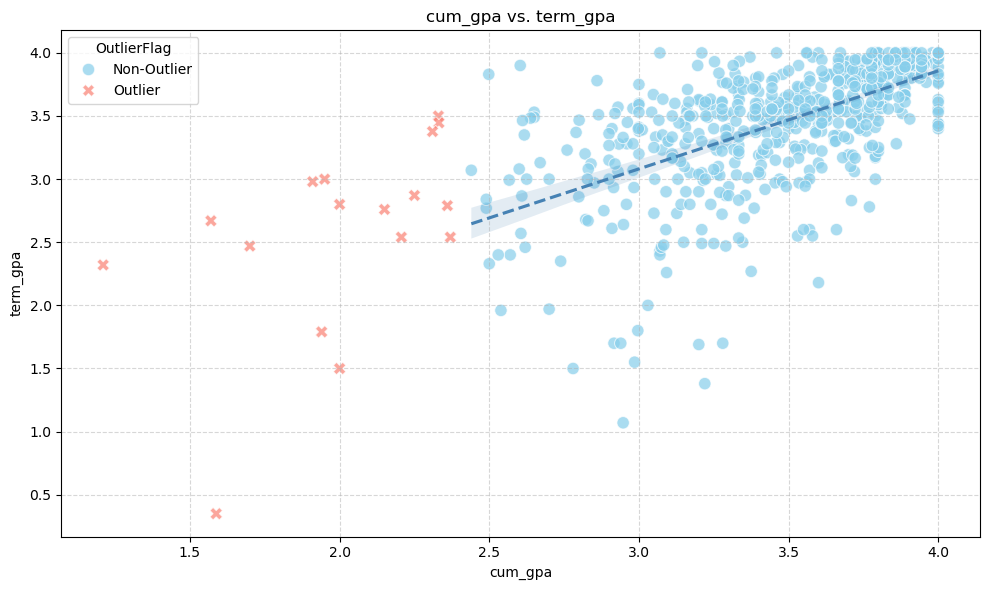


 [ cum_gpa Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 17
Outlier examples (top 5):
 cum_gpa   z_score  term_gpa
    1.57 -4.332026      2.67
    1.21 -5.154738      2.32
    1.94 -3.486461      1.79
    1.91 -3.555021      2.98
    2.15 -3.006546      2.76
------------------------------------------------------------


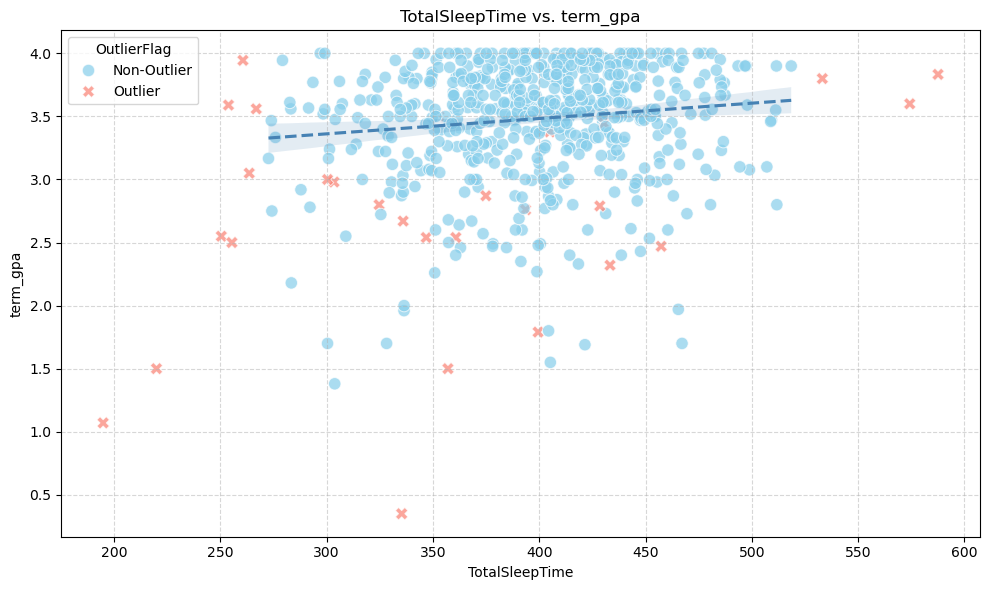


 [ TotalSleepTime Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 11
Outlier examples (top 5):
 TotalSleepTime   z_score  term_gpa
     266.833333 -2.565846  3.560000
     574.344828  3.480778  3.600000
     587.666667  3.742726  3.833333
     250.391304 -2.889147  2.550000
     253.764706 -2.822816  3.590000
------------------------------------------------------------


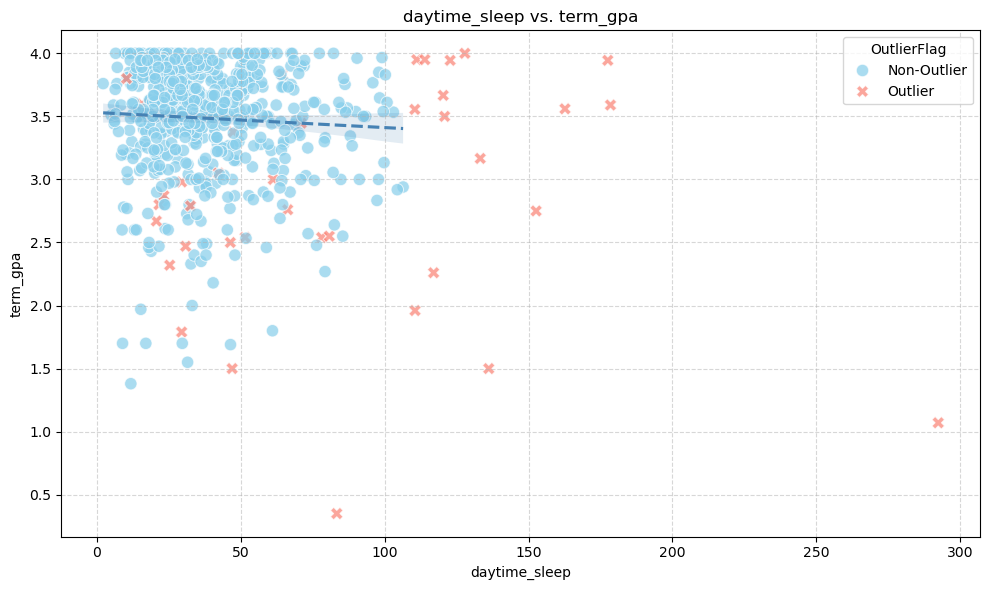


 [ daytime_sleep Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 16
Outlier examples (top 5):
 daytime_sleep  z_score  term_gpa
    162.666667 4.436108      3.56
    111.185185 2.556496      3.95
    178.470588 5.013117      3.59
    136.187500 3.469342      1.50
    152.642857 4.070135      2.75
------------------------------------------------------------


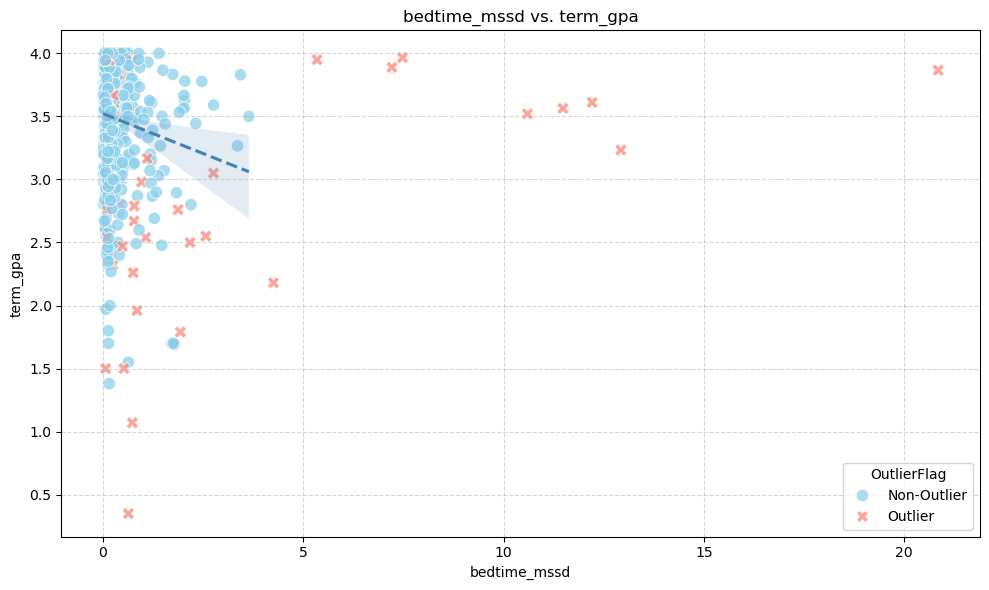


 [ bedtime_mssd Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 9
Outlier examples (top 5):
 bedtime_mssd  z_score  term_gpa
     5.344767 3.511026  3.950000
    12.928422 8.952675  3.233333
     7.477891 5.041649  3.966666
    10.595404 7.278618  3.520000
     4.255411 2.729360  2.180000
------------------------------------------------------------


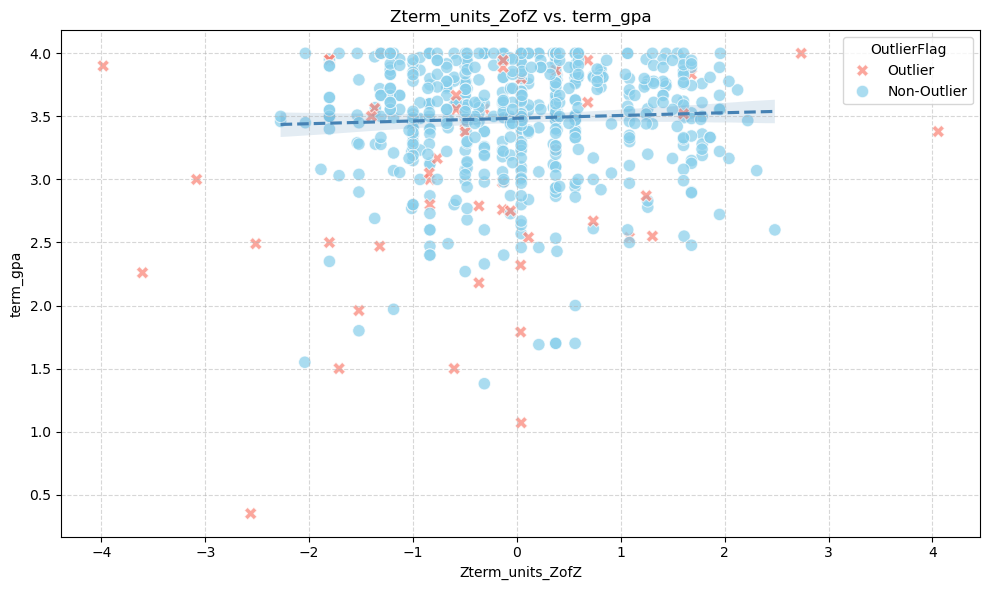


 [ Zterm_units_ZofZ Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 7
Outlier examples (top 5):
 Zterm_units_ZofZ   z_score  term_gpa
         4.055593  4.055593      3.38
        -2.513322 -2.513322      2.49
         2.736453  2.736453      4.00
        -3.982814 -3.982814      3.90
        -3.083268 -3.083268      3.00
------------------------------------------------------------


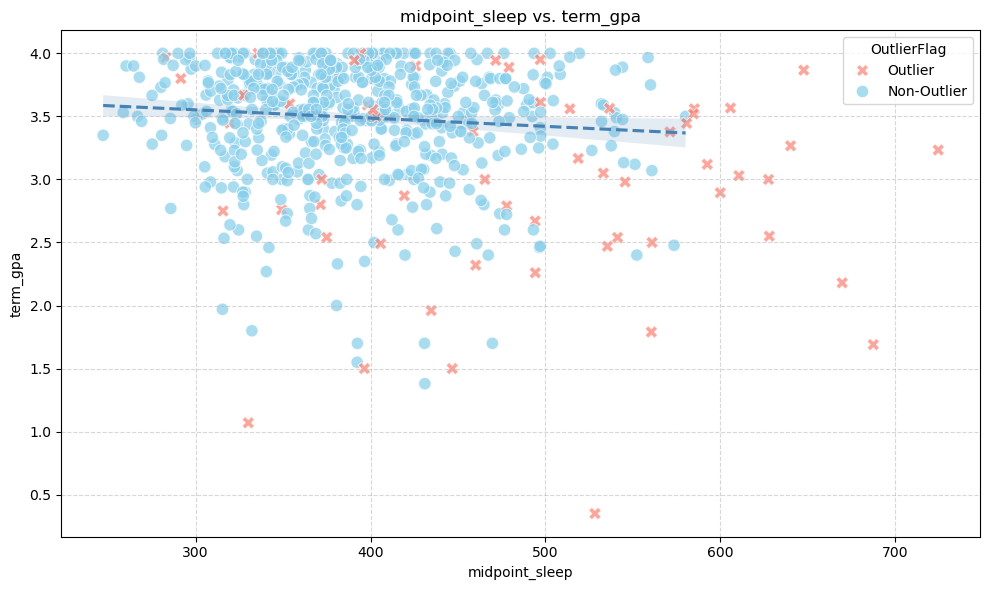


 [ midpoint_sleep Outlier Detection Result (Z-score, threshold=2.5) ]
Number of outliers: 14
Outlier examples (top 5):
 midpoint_sleep  z_score  term_gpa
     687.500000 3.972178      1.69
     592.553571 2.666371      3.12
     610.666667 2.915482      3.03
     628.043478 3.154467      2.55
     585.194444 2.565161      3.56
------------------------------------------------------------

Total number of detected outliers across all features: 74 (based on Z-score)



In [30]:
def visualize_and_report_outliers(df: pd.DataFrame, target_gpa_column: str, outlier_info_dict: dict, feature_list: list):
    """
    Visualize outliers for each feature and display the summary of detected outliers based on Z-score.

    Args:
        df (pd.DataFrame): Original DataFrame.
        target_gpa_column (str): Name of the target GPA column.
        outlier_info_dict (dict): Dictionary containing Z-score-based outlier information for each feature.
        feature_list (list): List of features to analyze.
    """
    print(f"\nTarget variable: {target_gpa_column}\n")

    total_outliers = 0  # Counter to keep track of total outliers

    # Add a flag column for outlier status
    df["OutlierFlag"] = "Non-Outlier"

    for feature in feature_list:
        outlier_idx = outlier_info_dict[feature]["index"]

        # Mark detected outliers in the flag column
        df.loc[df.index.isin(outlier_idx), "OutlierFlag"] = "Outlier"

        # Prepare data for visualization
        plot_df = df[[feature, target_gpa_column, "OutlierFlag"]].dropna()

        # Scatter plot with regression line
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=plot_df,
            x=feature, y=target_gpa_column,
            hue="OutlierFlag", style="OutlierFlag",
            palette={"Non-Outlier": "skyblue", "Outlier": "salmon"},
            markers={"Non-Outlier": "o", "Outlier": "X"},
            s=80, alpha=0.7
        )
        sns.regplot(
            data=plot_df[plot_df["OutlierFlag"] == "Non-Outlier"],
            x=feature,
            y=target_gpa_column,
            scatter=False,  # Only draw the regression line (scatter already drawn)
            line_kws={"color": "steelblue", "linestyle": "--"}
        )
        plt.title(f'{feature} vs. {target_gpa_column}')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Output detected outlier information
        result_df = outlier_info_dict[feature]
        count = len(result_df)
        total_outliers += count

        print(f"\n [ {feature} Outlier Detection Result (Z-score, threshold=2.5) ]")
        print(f"Number of outliers: {count}")
        if count > 0:
            # Merge visualization outliers with Z-score data
            outlier_rows = plot_df[plot_df["OutlierFlag"] == "Outlier"]
            merged = outlier_rows.merge(result_df, left_index=True, right_on="index")
            print("Outlier examples (top 5):")
            print(merged[[feature, "z_score", target_gpa_column]].head(5).to_string(index=False))
        else:
            print("No outliers detected.")
        print("-" * 60)

    print(f"\nTotal number of detected outliers across all features: {total_outliers} (based on Z-score)\n")

# Run visualization and reporting
visualize_and_report_outliers(
    df=df,
    target_gpa_column="term_gpa",
    outlier_info_dict=outliers_by_feature,
    feature_list=outlier_features
)

# 7. Outlier Process

  [cum_gpa] 12 outliers identified for imputation.
  Values before imputation:
      cum_gpa  term_gpa
27   1.570000  2.670000
60   1.910000  2.980000
68   2.150000  2.760000
88   2.330000  3.500000
98   2.000000  2.800000
100  1.950000  3.000000
155  2.331817  3.446153
160  2.310344  3.376923
161  2.249999  2.870588
179  2.370000  2.540000
201  2.206364  2.540000
417  2.360000  2.790000
  [cum_gpa] Values after KNN imputation:
      cum_gpa  term_gpa
27   3.191533  2.670000
60   3.402000  2.980000
68   3.336000  2.760000
88   3.576000  3.500000
98   3.422000  2.800000
100  3.256000  3.000000
155  3.342715  3.446153
160  3.556508  3.376923
161  3.265757  2.870588
179  3.200033  2.540000
201  3.034294  2.540000
417  3.046000  2.790000


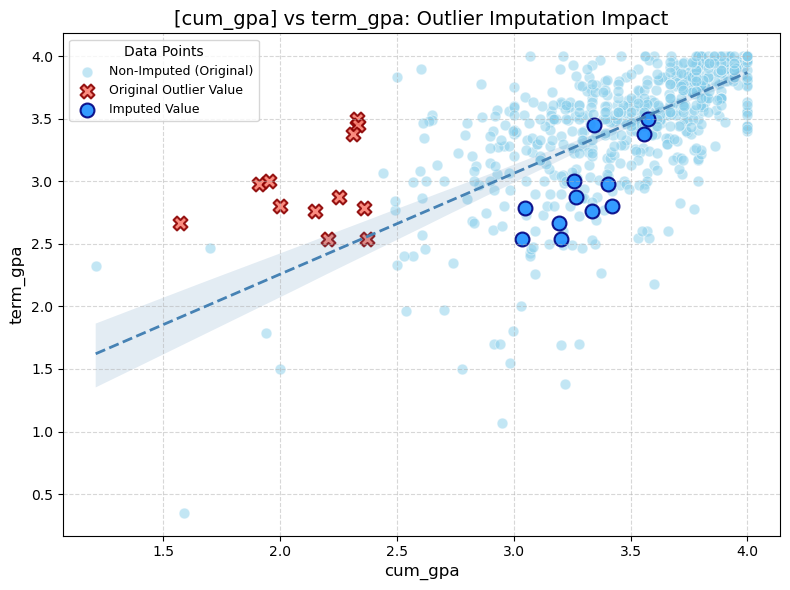

----------------------------------------------------------------------
  [TotalSleepTime] 9 outliers identified for imputation.
  Values before imputation:
     TotalSleepTime  term_gpa
74       266.833333  3.560000
99       574.344828  3.600000
134      587.666667  3.833333
181      250.391304  2.550000
227      253.764706  3.590000
282      255.370370  2.500000
405      263.529412  3.050000
460      533.214286  3.800000
612      260.571429  3.944500
  [TotalSleepTime] Values after KNN imputation:
     TotalSleepTime  term_gpa
74       343.860504  3.560000
99       366.906906  3.600000
134      428.601905  3.833333
181      354.402963  2.550000
227      321.963136  3.590000
282      408.516583  2.500000
405      345.094856  3.050000
460      467.517725  3.800000
612      350.410805  3.944500


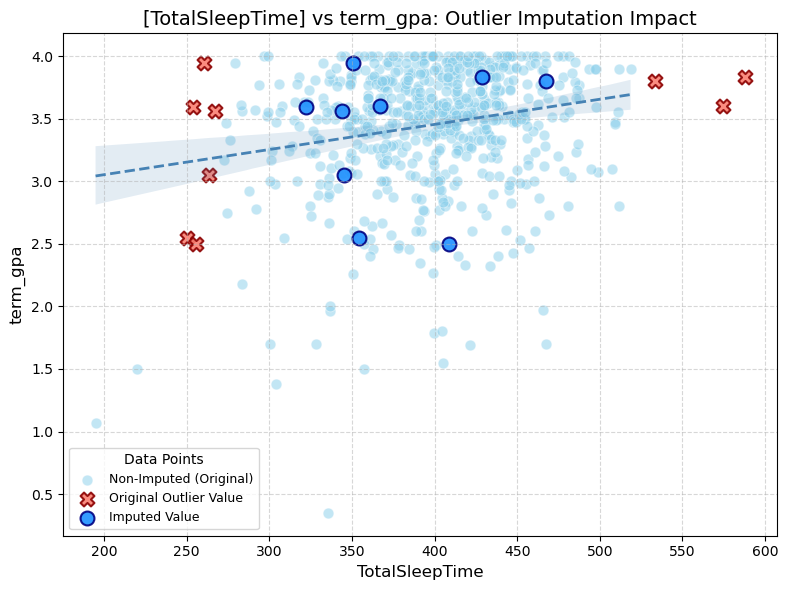

----------------------------------------------------------------------
  [daytime_sleep] 12 outliers identified for imputation.
  Values before imputation:
     daytime_sleep  term_gpa
74      162.666667  3.560000
193     111.185185  3.950000
227     178.470588  3.590000
272     152.642857  2.750000
295     114.000000  3.950000
501     122.793103  3.944500
505     127.900000  4.000000
560     120.862069  3.500000
575     110.517241  3.555500
591     133.238095  3.166500
612     177.535714  3.944500
620     120.379310  3.666667
  [daytime_sleep] Values after KNN imputation:
     daytime_sleep  term_gpa
74       34.262229  3.560000
193      73.404598  3.950000
227      39.293090  3.590000
272      51.796720  2.750000
295      43.461506  3.950000
501      45.280422  3.944500
505      64.357389  4.000000
560      64.583142  3.500000
575      42.267832  3.555500
591      66.956315  3.166500
612      35.464289  3.944500
620      55.376614  3.666667


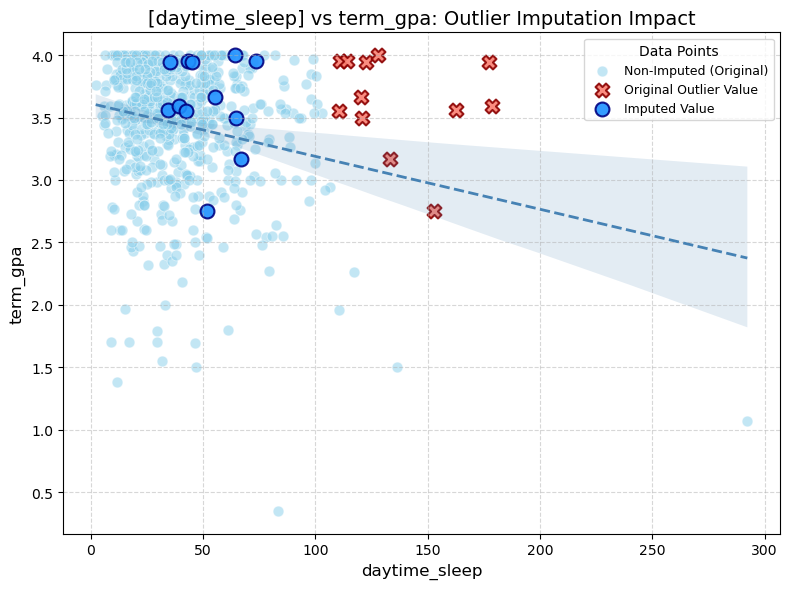

----------------------------------------------------------------------
  [bedtime_mssd] 8 outliers identified for imputation.
  Values before imputation:
     bedtime_mssd  term_gpa
295      5.344767  3.950000
302     12.928422  3.233333
309      7.477891  3.966666
389     10.595404  3.520000
430     11.480295  3.563636
452     20.849225  3.866666
524     12.210550  3.611000
607      7.211888  3.889000
  [bedtime_mssd] Values after KNN imputation:
     bedtime_mssd  term_gpa
295      0.404152  3.950000
302      2.263226  3.233333
309      0.219498  3.966666
389      2.028018  3.520000
430      1.362141  3.563636
452      2.188231  3.866666
524      1.185000  3.611000
607      0.387521  3.889000


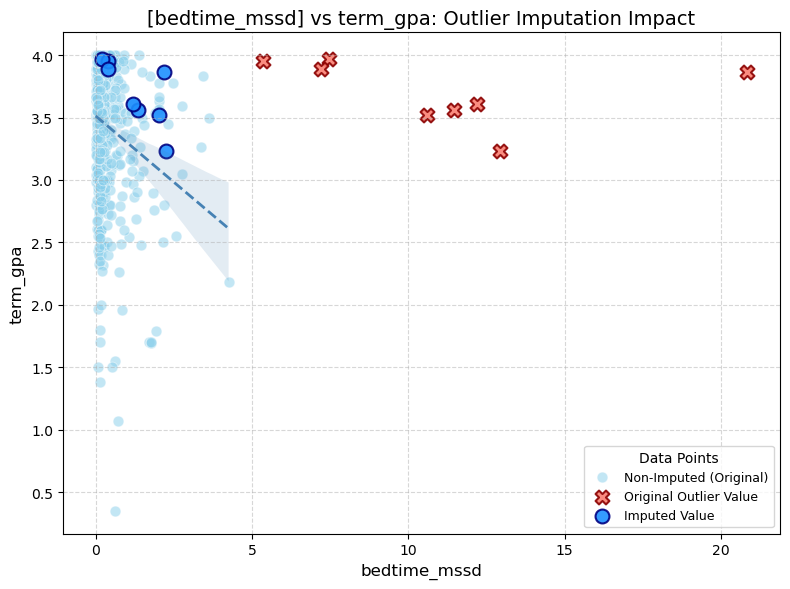

----------------------------------------------------------------------
  [Zterm_units_ZofZ] 2 outliers identified for imputation.
  Values before imputation:
     Zterm_units_ZofZ  term_gpa
421         -3.982814       3.9
457         -3.083268       3.0
  [Zterm_units_ZofZ] Values after KNN imputation:
     Zterm_units_ZofZ  term_gpa
421         -0.234100       3.9
457          0.037547       3.0


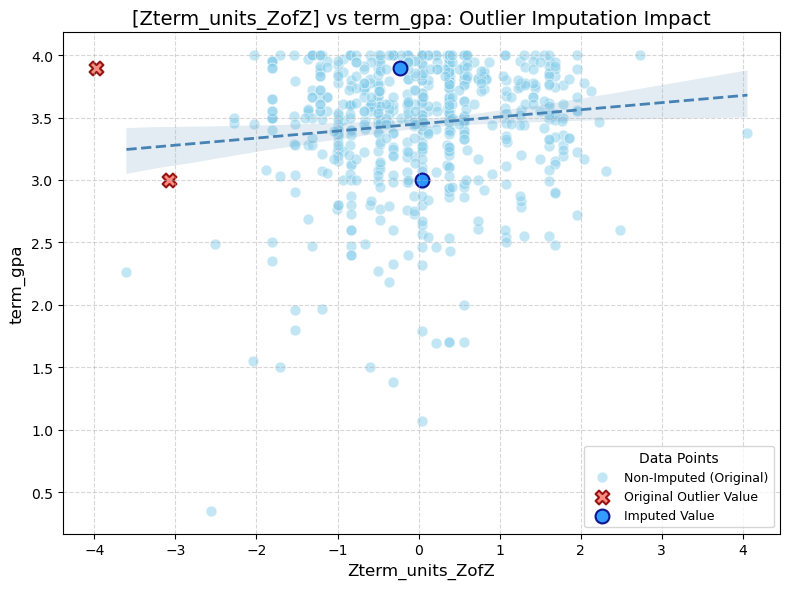

----------------------------------------------------------------------
  [midpoint_sleep] 12 outliers identified for imputation.
  Values before imputation:
     midpoint_sleep  term_gpa
113      592.553571  3.120000
127      610.666667  3.030000
181      628.043478  2.550000
242      585.194444  3.560000
263      627.592593  3.000000
284      640.227273  3.266666
298      605.863636  3.566666
302      724.666667  3.233333
389      584.666667  3.520000
446      600.029412  2.894444
452      647.750000  3.866666
625      580.781250  3.444500
  [midpoint_sleep] Values after KNN imputation:
     midpoint_sleep  term_gpa
113      379.037206  3.120000
127      468.920107  3.030000
181      477.745789  2.550000
242      464.915230  3.560000
263      437.893030  3.000000
284      497.714771  3.266666
298      489.317766  3.566666
302      475.774476  3.233333
389      472.618226  3.520000
446      439.122879  2.894444
452      503.955826  3.866666
625      480.285067  3.444500


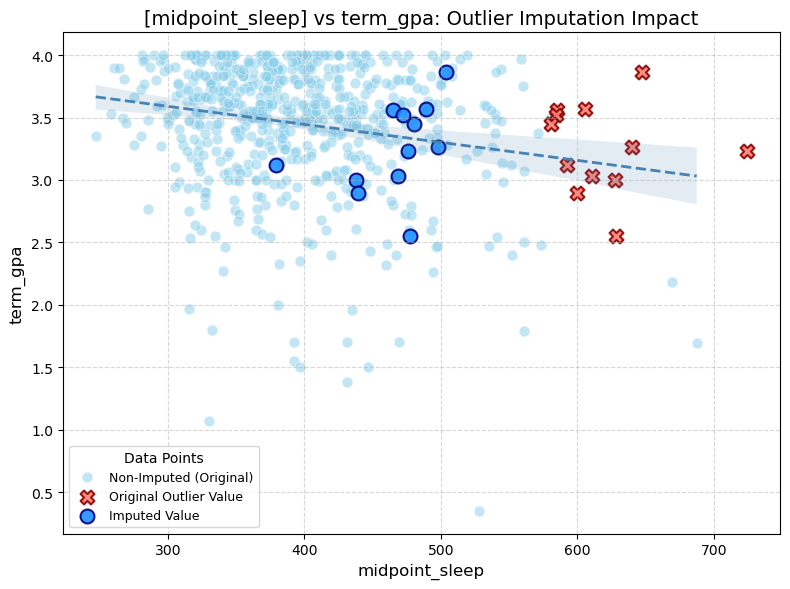

----------------------------------------------------------------------


In [36]:
def process_and_visualize_feature_outliers(
    df_original,
    feature_to_process,
    all_major_features,
    outlier_info_for_feature,
    target_gpa_col="term_gpa",
    impute_condition_logic=None,
    knn_k=5,
    visualize=True
    ):
    """
    Identifies and imputes outliers for a specific feature using KNNImputer,
    based on a logical condition related to the GPA target variable,
    and optionally visualizes the results.

    Args:
        df_original (pd.DataFrame): Original input DataFrame
        feature_to_process (str): Name of the feature to impute
        all_major_features (list): List of features to use for KNN training
        outlier_info_for_feature (pd.DataFrame): Z-score-based outlier info for this feature
        target_gpa_col (str): Target variable for GPA (default: "term_gpa")
        impute_condition_logic (callable): Function that defines the logic to decide which outliers to impute
        knn_k (int): Number of neighbors for KNN imputation
        visualize (bool): Whether to visualize imputation results
    Returns:
        pd.DataFrame: A new DataFrame with outliers imputed (original remains unchanged)
    """
    
    df_processed = df_original.copy()  # Copy the original DataFrame to avoid modifying it

    # Merge the outlier info with the actual GPA values for further condition-based filtering
    merged_info = pd.merge(outlier_info_for_feature, df_processed[[target_gpa_col]], left_on='index', right_index=True)

    # Apply the logic function to determine which outliers to impute
    indices_to_impute = merged_info.loc[impute_condition_logic(merged_info, target_gpa_col), 'index'].tolist()

    if not indices_to_impute:
        print(f"  [{feature_to_process}] No outliers matched the imputation condition.")
        print("-" * 70)
        return df_processed

    print(f"  [{feature_to_process}] {len(indices_to_impute)} outliers identified for imputation.")
    print(f"  Values before imputation:\n{df_processed.loc[indices_to_impute, [feature_to_process, target_gpa_col]]}")

    # Create a temporary copy and mark the selected outliers as NaN
    df_temp = df_processed.copy()
    df_temp.loc[indices_to_impute, feature_to_process] = np.nan

    # Explicitly define the features to use for KNN imputation
    knn_features = [
        "TotalSleepTime", "cum_gpa", "midpoint_sleep", "daytime_sleep",
        "Zterm_units_ZofZ", "bedtime_mssd", "term_units", "frac_nights_with_data",
        "term_gpa"
    ]
    data_for_imputer = df_temp[knn_features]

    # Standardize the data before applying KNN (as it is scale-sensitive)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_for_imputer)
    imputer = KNNImputer(n_neighbors=knn_k)
    imputed_scaled_data = imputer.fit_transform(scaled_data)

    # Restore original scale after imputation
    recovered_data = scaler.inverse_transform(imputed_scaled_data)

    imputed_df = pd.DataFrame(
        recovered_data,
        columns=knn_features,
        index=data_for_imputer.index
    )

    # Update the imputed values in the copied DataFrame
    df_processed.loc[indices_to_impute, feature_to_process] = imputed_df.loc[indices_to_impute, feature_to_process]

    print(f"  [{feature_to_process}] Values after KNN imputation:\n{df_processed.loc[indices_to_impute, [feature_to_process, target_gpa_col]]}")

    
    # Visualization (Before/After Imputation)
    if visualize:
        plt.figure(figsize=(8, 6))  

        # Non-outliers (Original): Original data points that are not imputed 
        non_imputed_original_data = df_original.drop(index=indices_to_impute, errors='ignore')
        sns.scatterplot(
            data=non_imputed_original_data,
            x=feature_to_process, y=target_gpa_col,
            color="skyblue",      # Color for non-outliers (background)
            marker="o",           # Circular marker
            s=60,                 # Dot size (slightly smaller for background feel)
            alpha=0.5,            # Transparency (lighter for background)
            edgecolor='white',    # Dot border color
            label="Non-Imputed (Original)"  # Legend label
        )

        # Original Outlier Values: Outliers before imputation (red X)
        sns.scatterplot(
            x=df_original.loc[indices_to_impute, feature_to_process],
            y=df_original.loc[indices_to_impute, target_gpa_col],  # GPA remains unchanged
            color="salmon",       # Outlier color
            marker="X",           # X-shaped marker
            s=100,                # Dot size (highlighted)
            alpha=0.9,            # Less transparent for visibility
            edgecolor='darkred',  # Border color for X marker
            linewidth=1.5,        # Border width for X
            label="Original Outlier Value"  # Legend label
        )

        # Imputed Values: New values imputed using KNN (blue O)
        sns.scatterplot(
            x=df_processed.loc[indices_to_impute, feature_to_process],
            y=df_processed.loc[indices_to_impute, target_gpa_col],  # GPA is the same
            color="dodgerblue",   # Color for imputed values
            marker="o",           # Circle marker (distinguished by color/border)
            s=100,                # Same size as outliers for comparison
            alpha=0.9,
            edgecolor='navy',     # Distinct border color
            linewidth=1.5,
            label="Imputed Value"  # Legend label
        )

        # Regression trend line for non-outlier data
        if not non_imputed_original_data.empty:  # Plot only if non-imputed data exists
            sns.regplot(
                data=non_imputed_original_data,
                x=feature_to_process, y=target_gpa_col,
                scatter=False,  # Skip scatter as it's already plotted
                line_kws={"color": "steelblue", "linestyle": "--", "linewidth": 2}  # Regression line style
                # Note: regplot does not auto-add to legend
            )

        plt.title(f"[{feature_to_process}] vs {target_gpa_col}: Outlier Imputation Impact", fontsize=14)
        plt.xlabel(feature_to_process, fontsize=12)
        plt.ylabel(target_gpa_col, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)  # Show grid
        plt.legend(title="Data Points", loc='best', frameon=True, fontsize=9)  # Configure legend
        plt.tight_layout()  # Auto layout adjustment
        plt.show()  # Display the plot

    print("-" * 70)
    return df_processed

# Define imputation logic for each feature

def cum_gpa_impute_logic(merged_info_df, gpa_col):
    # If cumulative GPA is very low (z < -2.5) but term GPA is 2.5 or higher, it contradicts the typical trend → mark for imputation
    return (merged_info_df['z_score'] < -2.5) & (merged_info_df[gpa_col] >= 2.5)

def total_sleep_time_impute_logic(merged_info_df, gpa_col):
    # If total sleep time is either very low (z < -2.5) or very high (z > 2.5) and term GPA is 2.5 or higher → mark for imputation
    condition_low_sleep_high_gpa = (merged_info_df['z_score'] < -2.5) & (merged_info_df[gpa_col] >= 2.5)
    condition_high_sleep_high_gpa = (merged_info_df['z_score'] > 2.5) & (merged_info_df[gpa_col] >= 2.5)
    return condition_low_sleep_high_gpa | condition_high_sleep_high_gpa

def daytime_sleep_impute_logic(merged_info_df, gpa_col):
    # If daytime sleep is very high (z > 2.5) and term GPA is 2.5 or higher → potential contradiction with typical sleep-academic performance patterns
    return (merged_info_df['z_score'] > 2.5) & (merged_info_df[gpa_col] >= 2.5)

def bedtime_mssd_impute_logic(merged_info_df, gpa_col):
    # If bedtime variability is very high (z > 2.5) and term GPA is 2.5 or higher → mark as exceptional case for imputation
    return (merged_info_df['z_score'] > 2.5) & (merged_info_df[gpa_col] >= 2.5)

def zterm_units_zofz_impute_logic(merged_info_df, gpa_col):
    # If normalized course load is very low (z < -2.5) and term GPA is 2.5 or higher,
    # or if it's very high (z > 2.5) and term GPA is 2.0 or lower → mark for imputation due to mismatch
    cond1 = (merged_info_df['z_score'] < -2.5) & (merged_info_df[gpa_col] >= 2.5)
    cond2 = (merged_info_df['z_score'] > 2.5) & (merged_info_df[gpa_col] <= 2.0)
    return cond1 | cond2

def midpoint_sleep_impute_logic(merged_info_df, gpa_col):
    # If sleep midpoint is extremely late (z > 2.5) and term GPA is 2.5 or higher → may contradict typical behavior-performance pattern
    return (merged_info_df['z_score'] > 2.5) & (merged_info_df[gpa_col] >= 2.5)


# Map each feature to its corresponding conditional outlier logic
features_to_process_map = {
    "cum_gpa": cum_gpa_impute_logic,
    "TotalSleepTime": total_sleep_time_impute_logic,
    "daytime_sleep": daytime_sleep_impute_logic,
    "bedtime_mssd": bedtime_mssd_impute_logic,
    "Zterm_units_ZofZ": zterm_units_zofz_impute_logic,
    "midpoint_sleep": midpoint_sleep_impute_logic,
}

df_final_processed = df.copy()  # Start with a copy of the original DataFrame

for feature_name in outlier_features:
    # Proceed only if the feature has a defined imputation logic
    if feature_name in features_to_process_map:
        current_outlier_info = outliers_by_feature[feature_name]
        logic_function_for_feature = features_to_process_map[feature_name]

        df_final_processed = process_and_visualize_feature_outliers(
            df_original=df_final_processed,
            feature_to_process=feature_name,
            all_major_features=outliers_by_feature,
            outlier_info_for_feature=current_outlier_info,
            target_gpa_col="term_gpa",
            impute_condition_logic=logic_function_for_feature,
            knn_k=5,
            visualize=True
        )

# 8. creation of Derived Feauters

In [39]:
# Create derived features based on the final cleaned dataset
# These features aim to better represent the characteristics of the data and improve model performance

# Derived Feature 1: Sleep Consistency Index
# Definition: (TotalSleepTime) / (bedtime_mssd + 1)
# Purpose: Combines the quantity and regularity of sleep into one indicator
#          TotalSleepTime: Total sleep duration during the main sleep window (minutes)
#          bedtime_mssd: Mean squared successive difference of bedtime (in minutes). Higher values indicate more irregular sleep times.
#          Adding 1 to the denominator prevents division by zero (in case of perfect regularity),
#          and amplifies the index when bedtime variability is low to reflect positive effects of regularity.
# Interpretation: Higher values imply longer and more regular sleep.
df_final_processed['sleep_consistency_index'] = df_final_processed['TotalSleepTime'] / (df_final_processed['bedtime_mssd'] + 1)

# Derived Feature 2: Sleep Efficiency Relative to Academic Load (sleep_efficiency_z)
# Definition: (TotalSleepTime + daytime_sleep) / (np.exp(Zterm_units_ZofZ) + epsilon)
# Purpose: Measures total sleep input (main + nap) relative to academic burden (Z-score of term units)
#          np.exp is used to ensure the denominator is positive and reduce interpretability issues when Z is near or below zero
#          epsilon is added to avoid division by zero in rare cases where Zterm_units_ZofZ ≈ -∞
epsilon = 1e-6
df_final_processed['sleep_efficiency_z'] = \
    (df_final_processed['TotalSleepTime'] + df_final_processed['daytime_sleep']) / \
    (np.exp(df_final_processed['Zterm_units_ZofZ']) + epsilon)

# Derived Feature 3: Daytime Sleep Proportion (day_night_ratio)
# Definition: daytime_sleep / (TotalSleepTime + daytime_sleep)
# Purpose: Indicates how much of total sleep is taken during the day (nap). Higher values suggest greater dependency on daytime sleep.
total_sleep_for_ratio = df_final_processed['TotalSleepTime'] + df_final_processed['daytime_sleep']
df_final_processed['day_night_ratio'] = np.where(
    total_sleep_for_ratio > 0,
    df_final_processed['daytime_sleep'] / total_sleep_for_ratio,
    0
)

# Derived Feature 4: Sleep Debt
# Definition: np.maximum(0, RECOMMENDED_SLEEP_MINUTES - TotalSleepTime)
# Purpose: Captures how much the student is under-sleeping relative to a recommended amount (e.g., 7 hours = 420 minutes)
RECOMMENDED_SLEEP_MINUTES = 420
df_final_processed['sleep_debt'] = np.maximum(0, RECOMMENDED_SLEEP_MINUTES - df_final_processed['TotalSleepTime'])

# Preview the newly created derived features (top 5 rows)
created_derived_features = [
    'sleep_consistency_index', 'sleep_efficiency_z', 
    'day_night_ratio', 'sleep_debt'
]
print("\nPreview of derived features (top 5 rows):")
print(df_final_processed[created_derived_features].head())

# Optionally display descriptive statistics for the derived features
print("\nDescriptive statistics of derived features:")
print(df_final_processed[created_derived_features].describe())


Preview of derived features (top 5 rows):
   sleep_consistency_index  sleep_efficiency_z  day_night_ratio  sleep_debt
0               387.023883            7.906527         0.052941    0.000000
1               343.292995           33.829744         0.032434   28.068965
2               136.126904           35.733760         0.041631   75.695652
3               347.406297           63.087296         0.121993   27.379310
4               374.648920           61.221500         0.024257    0.000000

Descriptive statistics of derived features:
       sleep_consistency_index  sleep_efficiency_z  day_night_ratio  \
count               634.000000          634.000000       634.000000   
mean                326.848707          699.764249         0.089974   
std                  86.023200          967.878381         0.052099   
min                  53.912688            7.906527         0.005902   
25%                 288.187743          247.877779         0.053937   
50%                 340.934449

### Feature importance with Engineered Features

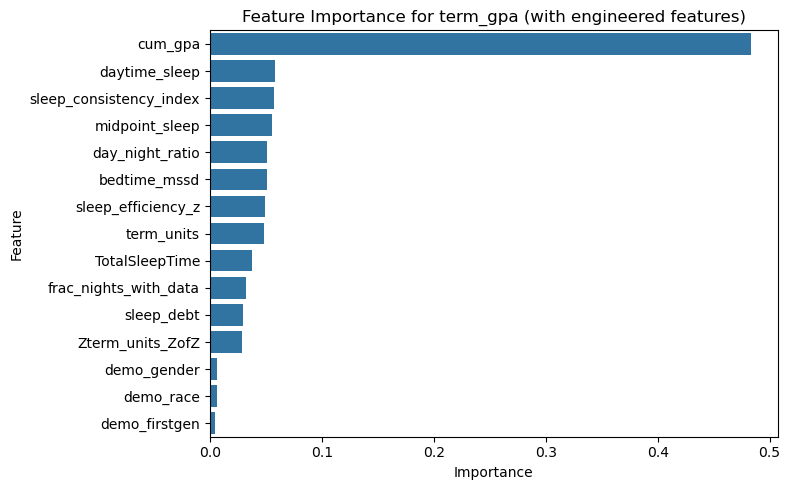

In [42]:
# Full list of features including derived variables
features = [
    'TotalSleepTime', 'bedtime_mssd', 'midpoint_sleep', 'daytime_sleep',
    'cum_gpa', 'Zterm_units_ZofZ', 'demo_gender', 'demo_race', 'demo_firstgen',
    'term_units', 'frac_nights_with_data',

    # Added engineered features
    'sleep_consistency_index',
    'sleep_efficiency_z',
    'day_night_ratio',
    'sleep_debt'
]

# Prepare data by dropping rows with missing values
df_clean = df_final_processed[features + ['term_gpa']].dropna()
X = df_clean[features]
y = df_clean['term_gpa']

# Call feature importance visualization function
importance_table = get_feature_importance(
    X, y,
    model=RandomForestRegressor(random_state=42),
    title="Feature Importance for term_gpa (with engineered features)"
)

# 9. Scaling

In [50]:
from sklearn.preprocessing import RobustScaler

# Sleep-related features to be scaled
sleep_features_to_scale = [
    'TotalSleepTime', 'bedtime_mssd', 'midpoint_sleep', 'daytime_sleep',
    'cum_gpa', 'term_units', 'Zterm_units_ZofZ',

    # Additional engineered features
    'sleep_consistency_index',
    'sleep_efficiency_z',
    'day_night_ratio',
    'sleep_debt'
]

# Apply RobustScaler
scaler = RobustScaler()
df_final_processed[sleep_features_to_scale] = scaler.fit_transform(df_final_processed[sleep_features_to_scale])

# Check the result
print(df_final_processed[sleep_features_to_scale].head())

   TotalSleepTime  bedtime_mssd  midpoint_sleep  daytime_sleep   cum_gpa  \
0        0.504870     -0.085484        0.775010      -0.389379 -1.044444   
1       -0.134373      0.031210       -0.246245      -0.789163  0.186508   
2       -0.890414      6.520235        1.883400      -0.723201  0.018651   
3       -0.123425     -0.022720        0.317725       0.712968  0.093254   
4        0.365510     -0.022568       -0.199650      -0.883890 -0.652777   

   term_units  Zterm_units_ZofZ  sleep_consistency_index  sleep_efficiency_z  \
0    1.709677          3.243484                 0.472763           -0.716797   
1    1.419355          1.972654                 0.024193           -0.673263   
2    1.387097          1.831450                -2.100816           -0.670066   
3    1.322581          1.549044                 0.066385           -0.624130   
4    1.322581          1.549044                 0.345827           -0.627263   

   day_night_ratio  sleep_debt  
0        -0.464054   -0.37017

# 10. Binning

In [54]:
# Define GPA binning thresholds and corresponding labels
bins = [0.0, 3.3, 3.7, 4.0]
labels = ["Low", "Mid", "High"]

# Assign GPA class labels based on term_gpa ranges
df_final_processed["gpa_class"] = pd.cut(df_final_processed["term_gpa"], bins=bins, labels=labels, include_lowest=True)

# Check the distribution of GPA classes
print(df_final_processed["gpa_class"].value_counts())

gpa_class
High    226
Mid     223
Low     185
Name: count, dtype: int64


In [58]:
# Save the currently processed DataFrame to a CSV file
df_final_processed.to_csv("preprocessed_cmudata.csv", index=False, encoding="utf-8-sig")